# Import Data

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [90]:
# ----------------------------
# Import des modules de bases
# ----------------------------
import os
import datetime as dt
import six
import numpy as np
import numpy.random as rd 
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [91]:
pip install kaggle

In [92]:
# ----------------------------------
# Import necessary file
# Select file kaggle.json
# ----------------------------------

from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [93]:
# ---------------------------------------------
# Branchement à Kaggle pour import des données
# ---------------------------------------------

!pip install -q kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [94]:
# -------------------
# Import des données
# -------------------
!kaggle competitions download -c 3md3070-dlmi

3md3070-dlmi.zip: Skipping, found more recently modified local copy (use --force to force download)


In [95]:
# ---------------------------------
# Dézipage des fichiers de données
# ---------------------------------
!unzip -qq '3md3070-dlmi'.zip

replace clinical_annotation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Exploration

## Support functions

In [96]:
def get_nb_images(dataset, patientID):
  'returns the number of images for a given patient'
  return len([name for name in os.listdir('/content/'+dataset+'/P'+str(patientID))])

In [97]:
def read_image(dataset, patientID, imageID):
  image_path = '/content/' + dataset + '/P' + str(patientID) + '/{:06d}'.format(imageID) + '.jpg'
  return cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

In [98]:
def imview(image, title):
  plt.figure(figsize=(4,4))
  plt.imshow(image)
  plt.axis('off')
  plt.title(title)

## TrainSet and TestSet Statistics (age, gender, labels, lymph_count)

#### Get meta data

In [99]:
trainset_meta = pd.read_csv('/content/trainset/trainset_true.csv')
testset_meta = pd.read_csv('/content/testset/testset_data.csv')

In [100]:
trainset_meta.head(5)

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,M,11/3/1933,11.2
1,P183,1,M,5/15/1942,12.8
2,P89,1,M,6/19/1935,9.6
3,P123,1,M,1/27/1931,122.6
4,P61,1,F,3/5/1931,11.6


In [101]:
testset_meta.head(5)

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P71,-1,M,1/17/1946,5.76
1,P16,-1,M,3/5/1940,32.00
2,P114,-1,M,6/16/1929,4.60
3,P170,-1,M,11/3/1933,4.80
4,P98,-1,F,5/14/1970,6.24


#### Extracting Age

Age and Year Of Brith (YOB) give the same relative information--> extracting age

In [102]:
trainset_meta['age'] = trainset_meta.apply(lambda row: dt.datetime.now().year - int(row.DOB.replace('-','/').split('/')[2]), axis=1)
testset_meta['age'] = testset_meta.apply(lambda row: dt.datetime.now().year - int(row.DOB.replace('-','/').split('/')[2]), axis=1)


#### Encoding Gender

In [103]:
# Male = 1, Female = 0
trainset_meta['GENDER'] = trainset_meta.apply(lambda row: 0 if row.GENDER == 'F' else 1, axis=1)
testset_meta['GENDER'] = testset_meta.apply(lambda row: 0 if row.GENDER == 'F' else 1, axis=1)

#### Statistics

In [ ]:
print(f'There are {trainset_meta.ID.nunique()} patients in the trainset')
print(f'There are {testset_meta.ID.nunique()} patients in the testset')

There are 163 patients in the trainset
There are 42 patients in the testset


In [ ]:
trainset_meta.groupby('LABEL').count()

,ID,GENDER,DOB,LYMPH_COUNT,age
LABEL,,,,,
0,50,50,50,50,50
1,113,113,113,113,113


In [ ]:
trainset_meta.describe().round(2)

,LABEL,GENDER,LYMPH_COUNT,age
count,163.00,163.00,163.00,163.00
mean,0.69,0.51,26.42,69.76
std,0.46,0.50,46.78,17.66
min,0.00,0.00,2.28,23.00
25%,0.00,0.00,5.04,61.00
50%,1.00,1.00,7.81,73.00
75%,1.00,1.00,20.44,84.50
max,1.00,1.00,295.00,100.00


In [ ]:
testset_meta.describe().round(2)

,LABEL,GENDER,LYMPH_COUNT,age
count,42.0,42.00,42.00,42.00
mean,-1.0,0.57,24.37,66.69
std,0.0,0.50,44.11,19.73
min,-1.0,0.00,4.08,22.00
25%,-1.0,0.00,5.17,56.00
50%,-1.0,1.00,6.76,68.00
75%,-1.0,1.00,22.38,82.50
max,-1.0,1.00,217.59,98.00


**TRAINSET \
---> Ratio Homme/Femme = 50.1% \
---> 69.3% des patients sont malades (label 1 - cancerous) \
---> Moyenne d'age = 69.7ans, 75% des patients ont plus de 73ans**

**TESTSET \
---> Ratio Homme/Femme = 57.1% \
---> Moyenne d'age = 66.7ans, 75% des patients ont plus de 56ans**


In [ ]:
# -----------------------------------
# mean Lynph_count sick VS healthy
# -----------------------------------
print(trainset_meta.groupby(['LABEL'])['LYMPH_COUNT'].mean(), '\n')

# -----------------------------------
# M/F ratio sick VS healthy
# -----------------------------------
print(trainset_meta.groupby(['LABEL'])['GENDER'].mean(), '\n')

# -----------------------------------
# age median sick VS healthy
# -----------------------------------
print(trainset_meta.groupby(['LABEL'])['age'].median(), '\n')

LABEL
0     5.005200
1    35.901239
Name: LYMPH_COUNT, dtype: float64 

LABEL
0    0.480000
1    0.522124
Name: GENDER, dtype: float64 

LABEL
0    53.5
1    77.0
Name: age, dtype: float64 



**---> Sick patients have a higher lymph_count \
---> Among sick patients there are more males than females \
---> Sick patients are older**

## Exemple patients 

#### Exemple patient malade

In [ ]:
patient_sick = trainset_meta[trainset_meta.LABEL == 1].sample(1).ID.values[0][1:]

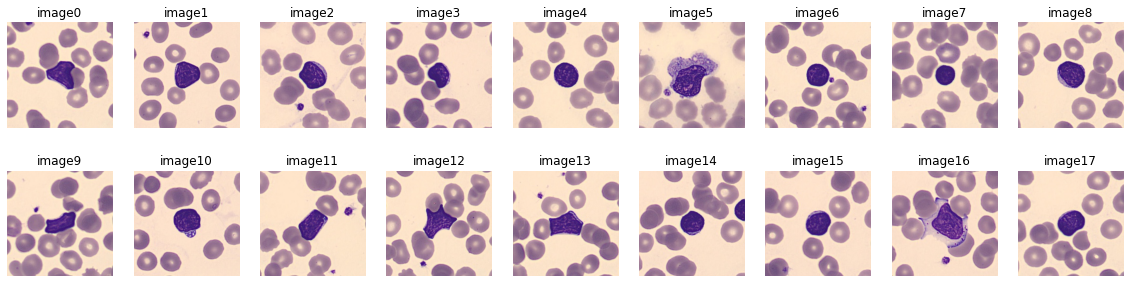

In [ ]:
nb_img = get_nb_images('trainset', patient_sick)
plt.figure(figsize=(20, 5))
for i in range(18):
  plt.subplot(2, 9, i+1)
  plt.imshow(read_image('trainset', patient_sick, i))
  plt.title('image'+str(i))
  plt.axis('off')

#### Exemple patient sain

In [ ]:
patient_healthy = trainset_meta[trainset_meta.LABEL == 0].sample(1).ID.values[0][1:]

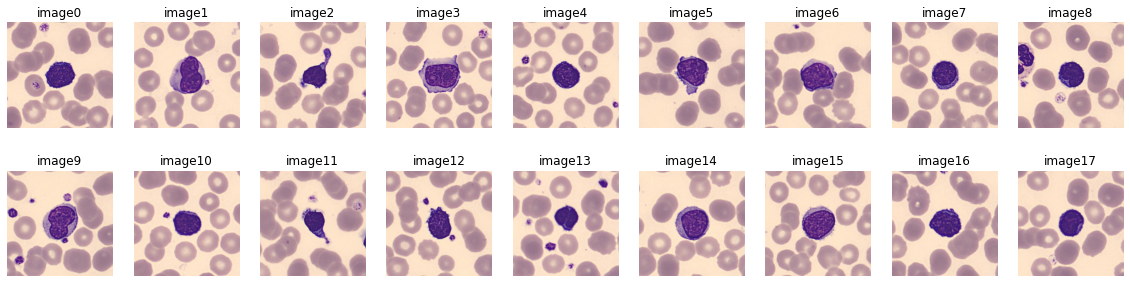

In [ ]:
nb_img = get_nb_images('trainset', patient_healthy)
plt.figure(figsize=(20, 5))
for i in range(18):
  plt.subplot(2, 9, i+1)
  plt.imshow(read_image('trainset', patient_healthy, i))
  plt.title('image'+str(i))
  plt.axis('off')

In [ ]:
tot_set = pd.concat([trainset_meta, testset_meta])
age_mean = np.mean(tot_set.age)
age_std = np.std(tot_set.age)

lymph_mean = np.mean(tot_set.LYMPH_COUNT)
lymph_std = np.std(tot_set.LYMPH_COUNT)

In [ ]:
trainset_meta['age_norm'] = trainset_meta.apply(lambda row : (row.age - age_mean) /age_std, axis=1 )
testset_meta['age_norm'] = testset_meta.apply(lambda row : (row.age - age_mean) /age_std, axis=1 )

trainset_meta['lymph_norm'] = trainset_meta.apply(lambda row : (row.LYMPH_COUNT - lymph_mean) /lymph_std, axis=1 )
testset_meta['lymph_norm'] = testset_meta.apply(lambda row : (row.LYMPH_COUNT - lymph_mean) /lymph_std, axis=1 )


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score


X_train, X_test, y_train, y_test = train_test_split(trainset_meta[['lymph_norm', 'age_norm']], trainset_meta['LABEL'], train_size=0.8, random_state=2, shuffle = True)

In [ ]:
len(X_train), len(X_test)

(130, 33)

In [ ]:
from sklearn.svm import SVC

param = {'C':[1.0, 10, 100], 'kernel':['linear', 'rbf']}

svc = SVC()
clf = GridSearchCV(svc, param, cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)

y_pred = clf.best_estimator_.predict(X_test)
print('val Accuracy :', accuracy_score(y_test, y_pred))
print('val Balanced Accuracy :', balanced_accuracy_score(y_test, y_pred))
print('val Recall  :', balanced_accuracy_score(y_test, y_pred))
print('val PRecision  :', balanced_accuracy_score(y_test, y_pred))

0.876923076923077
val Accuracy : 0.7575757575757576
val Balanced Accuracy : 0.7380952380952381
val Recall  : 0.7380952380952381
val PRecision  : 0.7380952380952381


In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('val Accuracy :', accuracy_score(y_test, y_pred))
print('val Balanced Accuracy :', balanced_accuracy_score(y_test, y_pred))
print('val Recall  :', balanced_accuracy_score(y_test, y_pred))
print('val PRecision  :', balanced_accuracy_score(y_test, y_pred))

val Accuracy : 0.8484848484848485
val Balanced Accuracy : 0.8809523809523809
val Recall  : 0.8809523809523809
val PRecision  : 0.8809523809523809


In [ ]:
from sklearn.linear_model import SGDClassifier

param = {'loss':['hinge', 'modified_huber', 'squared_hinge']}

sgd = SGDClassifier(penalty='l2', max_iter=100)
clf = GridSearchCV(sgd, param, cv=5)
clf.fit(X_train, y_train)
print(clf.best_score_)

y_pred = clf.best_estimator_.predict(X_test)
print('val Accuracy :', accuracy_score(y_test, y_pred))
print('val Balanced Accuracy :', balanced_accuracy_score(y_test, y_pred))
print('val Recall  :', balanced_accuracy_score(y_test, y_pred))
print('val PRecision  :', balanced_accuracy_score(y_test, y_pred))

0.8461538461538464
val Accuracy : 0.8181818181818182
val Balanced Accuracy : 0.8571428571428572
val Recall  : 0.8571428571428572
val PRecision  : 0.8571428571428572


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('val Accuracy :', accuracy_score(y_test, y_pred))
print('val Balanced Accuracy :', balanced_accuracy_score(y_test, y_pred))
print('val Recall  :', balanced_accuracy_score(y_test, y_pred))
print('val PRecision  :', balanced_accuracy_score(y_test, y_pred))


val Accuracy : 0.7878787878787878
val Balanced Accuracy : 0.7797619047619048
val Recall  : 0.7797619047619048
val PRecision  : 0.7797619047619048


# MIL model

### Models


We are going to implement the Mixure of experts descrive in the second figure (b) from the article [Deep Multi-Instance Learning Using Multi-Modal Data for Diagnosis of Lymphocytosis](https://hal.archives-ouvertes.fr/hal-03032875)

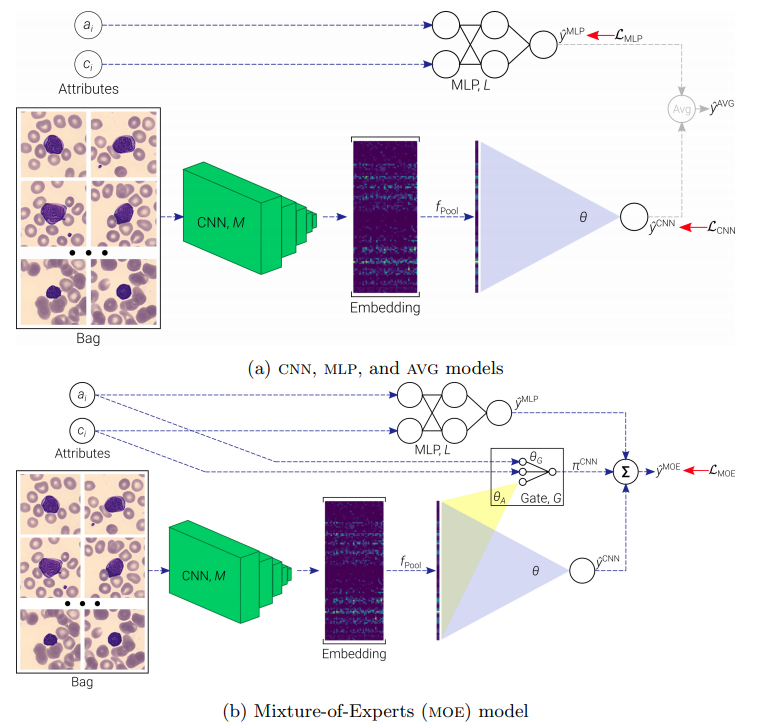

**ResNet**: embeddings extractor  
**CNN_Classifier**: Classify ResNet aggregated embeddings  
**CNN**: Joint model of the above ResNet and classifier  
**MLP**: MultiLayerPerceptron that classifies upoon patient attributes age + lymph_count  
**MOE**: Mixture of experts

In [104]:
# Import useful libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

torch.manual_seed(0)

#### Classifier

In [105]:
# Classifier of the averaged embeddings

class CNN_Classifier(nn.Module):
  def __init__(self, K):
    super(CNN_Classifier, self).__init__()
    self.linear1 = nn.Linear(7*7*8*K, 1, bias=True)

  def forward(self, x):
    x = self.linear1(x)
    return x

##### CNN

In [106]:
# Rotation of an PIL image in the set {0°, 90°, 180°, 270°}

def rotate(img):
  degree_range = [0,90,180,270]
  p = np.random.rand()
  return img.rotate(degree_range[int(p*4)])

In [107]:
# Dataset that will be employed inside the model to load a single patients data per batch

from PIL import Image
import torchvision.transforms as transforms

class PatientSet(Dataset):
  def __init__(self, patient_id, dataset='trainset'):
    super(PatientSet, self).__init__()
    self.patient_id = patient_id
    self.dataset = dataset

    self.nb_image = get_nb_images(self.dataset, self.patient_id[1:])
    patient_full_data = np.zeros((self.nb_image, 224, 224, 3))
    for i in range(self.nb_image):
      img = read_image(self.dataset, self.patient_id[1:], i)
      patient_full_data[i] = img
    
    self.patient_full_data = patient_full_data

    if self.dataset == 'trainset':
      self.transforms = transforms.Compose([
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          #transforms.Normalize([0.8185, 0.6992, 0.7039], [0.1930, 0.2147, 0.0932])
      ])
    else:
      self.transforms = transforms.Compose([
          #transforms.Normalize([0.8185, 0.6992, 0.7039], [0.1930, 0.2147, 0.0932])
      ])
    self.rotation = rotate

  def __len__(self):
    return self.nb_image

  def __getitem__(self, idx):
    img = self.patient_full_data[idx].astype(np.uint8)
    if self.dataset == 'testset':
      img = np.transpose(img, (2, 1, 0))/255.
      img = torch.from_numpy(img).float()
      img = self.transforms(img)
      return img
    else:
      img = Image.fromarray(img)
      img = self.rotation(img)
      img = np.transpose(np.array(img), (2, 1, 0))/255.
      img = torch.from_numpy(img).float()
      img = self.transforms(img)
      return img

In [108]:
# ResNet + Classifier model

from torchvision.models.resnet import BasicBlock, Bottleneck

class CNN_v2(nn.Module):
  def __init__(self):
    super(CNN_v2, self).__init__()
    self.resnet = models.ResNet(BasicBlock, [1, 1, 1, 1]) # ResNet of 10 layers (4 convolutional blocks)
    self.resnet.avgpool = nn.Identity()
    self.resnet.fc = nn.Identity()

    self.clf = CNN_Classifier(64)

  def forward(self, patient_id, device, dataset='trainset'):
    patientset = PatientSet(patient_id, dataset)
    patient_loader = DataLoader(patientset, batch_size=32, shuffle = True)
    for batch_id, x in enumerate(patient_loader):
      x = x.to(device)
      x = self.resnet(x)
      if batch_id == 0:
        x_agg = x
      else:
        x_agg = torch.cat((x_agg, x), dim=0)
    x_agg = torch.mean(x_agg, 0, True) # Average of embeddings
    y = self.clf(x_agg)
    return y.squeeze(1), x_agg

#### Multi Layer Perceptron

In [109]:
# MLP definition (will work with the patient attributes (age + lymph count))

class MLP(nn.Module):
  def __init__(self):
    super(MLP , self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
    )

  def forward(self, x):
    x = self.layers(x)
    return x.squeeze(-1)

#### Mixture of experts

In [110]:
# MOE model
# input:
#    - averaged image embeddings
#    - patient attributes
# output:
#    - CNN importance weight

class MOE(nn.Module):
  def __init__(self, embedding_size):
    super(MOE, self).__init__()
    
    self.thetaA = nn.Sequential(
        nn.Linear(embedding_size, 1),
    )
    self.thetaG = nn.Sequential(
        nn.Linear(3, 1),
    )

  def forward(self, x_cnn, x_attr):
    x_cnn = self.thetaA(x_cnn)
    prediction = torch.cat((x_cnn, x_attr), 1)
    prediction = self.thetaG(prediction)
    prediction = torch.sigmoid(prediction)

    return prediction.squeeze(-1)

### Loss functions

ResNet loss: **Binary cross entropy with logits loss**  
MLP loss: **Binary cross entropy with logits loss**  
MOE loss: **Binary cross entropy loss**  

### Training

Splitting the data into trainsing and validation set

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [112]:
# Training and validation set definition
index = trainset_meta.index
train_set_index, validation_set_index = train_test_split(index, train_size = 0.8, random_state=2, shuffle = True) #5: 0.7 0.66 #4: 0.68 0.73
train_set = trainset_meta.loc[train_set_index]
validation_set = trainset_meta.loc[validation_set_index]
train_ids = np.copy(train_set.ID.values)
validation_ids = np.copy(validation_set.ID.values)
print('Train set size -> ', train_set.shape[0], '1: ', train_set.LABEL.values.sum() / train_set.shape[0])
print('Validaiton set size -> ', validation_set.shape[0], '1: ', validation_set.LABEL.values.sum() / validation_set.shape[0])

Train set size ->  130 1:  0.7076923076923077
Validaiton set size ->  33 1:  0.6363636363636364


#### CNN training

In [42]:
device = 'cuda'
model = CNN_v2()
#model.load_state_dict(torch.load('/gdrive/MyDrive/model_CNN_30e.save'))
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

In [43]:
epochs = 100
training_loss_history = []
validation_loss_history = []
subj_batch_size = 16
best_val_loss = 1
for epoch in range(epochs):
  training_loss = 0
  model.train()
  accumulated_examples = 0
  predictions_train = []
  true_labels_train = []
  np.random.shuffle(train_ids)
  for batch_id, patient_id in enumerate(train_ids):

    if accumulated_examples == 0:
      optimizer.zero_grad()

    p_label = torch.from_numpy(train_set[train_set.ID == patient_id].LABEL.values)
    output, _ = model(patient_id, device, 'trainset')

    loss = criterion(output, p_label.float().to(device))
    pred_train = list(np.array((output > 0).int().cpu().detach()))
    predictions_train += pred_train
    true_labels_train += list(np.array(p_label.int().cpu().detach()))
    loss.backward()

    accumulated_examples += 1
    if accumulated_examples == subj_batch_size or batch_id + 1 == len(train_set.ID.values):
      for param in model.parameters():
        if param.grad is not None:
          param.grad *= 1./accumulated_examples
      
      accumulated_examples = 0
      optimizer.step()
    
    training_loss += loss.item()/len(train_set)
  training_loss_history.append(training_loss)

  model.eval()
  validation_loss = 0
  predictions = []
  true_labels = []
  for patient_id in validation_ids:
    p_label = torch.from_numpy(validation_set[validation_set.ID == patient_id].LABEL.values)
    output, _ = model(patient_id, device, 'trainset')

    loss = criterion(output, p_label.float().to(device))
    
    validation_loss += loss.item()/len(validation_set)
    pred = list(np.array((output > 0).int().cpu().detach()))
    predictions += pred
    true_labels += list(np.array(p_label.int().cpu().detach()))

  validation_loss_history.append(validation_loss)
  val_accuracy = accuracy_score(true_labels, predictions)
  val_balanced_accuracy = balanced_accuracy_score(true_labels, predictions)

  train_accuracy = accuracy_score(true_labels_train, predictions_train)
  train_balanced_accuracy = balanced_accuracy_score(true_labels_train, predictions_train)

  if validation_loss < best_val_loss:
    torch.save(model.state_dict(), '/content/CNN_final_100e.save')
    best_val_loss = validation_loss
  
  print('Epoch [',epoch+1, '/', epochs, ']:------------------------------------')
  print('Training loss -> ', round(training_loss, 4), 'Validation loss -> ', round(validation_loss, 4))
  print("Train Accuracy Score -> ", round(train_accuracy, 4), "; Train Balanced Accuracy Score -> ",round(train_balanced_accuracy, 4))
  print("Val Accuracy Score -> ", round(val_accuracy, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy, 4))
  print('----------------------------------------------------------------------')

Epoch [ 1 / 100 ]:------------------------------------
Training loss ->  0.7748 Validation loss ->  0.8707
Train Accuracy Score ->  0.6615 ; Train Balanced Accuracy Score ->  0.4828
Val Accuracy Score ->  0.3636 ; Val Balanced Accuracy Score ->  0.5
----------------------------------------------------------------------
Epoch [ 2 / 100 ]:------------------------------------
Training loss ->  0.8384 Validation loss ->  1.3009
Train Accuracy Score ->  0.5385 ; Train Balanced Accuracy Score ->  0.5503
Val Accuracy Score ->  0.6364 ; Val Balanced Accuracy Score ->  0.5
----------------------------------------------------------------------
Epoch [ 3 / 100 ]:------------------------------------
Training loss ->  0.7926 Validation loss ->  0.6556
Train Accuracy Score ->  0.6308 ; Train Balanced Accuracy Score ->  0.5152
Val Accuracy Score ->  0.6364 ; Val Balanced Accuracy Score ->  0.5357
----------------------------------------------------------------------
Epoch [ 4 / 100 ]:----------------

KeyboardInterrupt: ignored

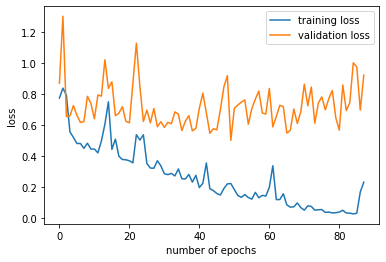

In [44]:
plt.plot(training_loss_history, label='training loss')
plt.plot(validation_loss_history, label='validation loss')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('loss')
#plt.savefig('/gdrive/MyDrive/DLMI/Project/train_val_loss.jpg')
plt.show()

#### MLP training

In [113]:
print('Mean age -> ', train_set.age.values.mean())
print('Std age -> ', train_set.age.values.std())
print('Mean lymph_count -> ', train_set.LYMPH_COUNT.values.mean())
print('Std lymph_count -> ', train_set.LYMPH_COUNT.values.std())

Mean age ->  70.64615384615385
Std age ->  16.903282129384287
Mean lymph_count ->  28.457615384615384
Std lymph_count ->  49.26176894609272


In [114]:
class MLP_Dataset(Dataset):
  def __init__(self, dataset):
    super(MLP_Dataset, self).__init__()
    self.dataset = dataset
    self.patient_ids = dataset.index.values
    #self.attr_mean = np.array([69.0, 21.43])
    #self.attr_std = np.array([17.5, 37.5])
    self.attr_mean = np.array([70.65, 28.46])
    self.attr_std = np.array([16.90, 49.26])
  
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    patient_index = self.patient_ids[idx]
    attributes = np.array([self.dataset.loc[patient_index].age.item(), self.dataset.loc[patient_index].LYMPH_COUNT.item()])
    attributes = (attributes - self.attr_mean)/self.attr_std
    label = self.dataset.loc[patient_index].LABEL

    return torch.tensor(attributes).float(), torch.tensor(label).float()

In [115]:
mlp_trainset = MLP_Dataset(train_set)
mlp_trainloader = DataLoader(mlp_trainset, batch_size=1, shuffle=True)
mlp_valset = MLP_Dataset(validation_set)
mlp_valloader = DataLoader(mlp_valset, batch_size=1, shuffle=True)

In [116]:
device = 'cuda'
mlp = MLP()
mlp.to(device)
criterion = nn.BCEWithLogitsLoss()
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(mlp_optimizer, step_size=150, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [117]:
epochs = 100
training_loss_history = []
validation_loss_history = []
best_val_loss = 2
for epoch in range(epochs):
  training_loss = 0
  mlp.train()
  predictions_train = []
  true_labels_train = []
  for attributes, label in mlp_trainloader:
    attributes, label = attributes.to(device), label.to(device)
    mlp_optimizer.zero_grad()

    output = mlp(attributes)

    loss = criterion(output, label)

    pred_train = list(np.array((output > 0).int().cpu().detach()))
    predictions_train += pred_train
    true_labels_train += list(np.array(label.int().cpu().detach()))

    loss.backward()

    mlp_optimizer.step()
    
    training_loss += loss.item()/len(train_set)
  training_loss_history.append(training_loss)
  lr_scheduler.step()

  mlp.eval()
  validation_loss = 0
  predictions = []
  true_labels = []
  pred_raw = []
  for attributes, label in mlp_valloader:
    attributes, label = attributes.to(device), label.to(device)
    output = mlp(attributes)

    loss = criterion(output, label)
    
    validation_loss += loss.item()/len(validation_set)
    pred_raw += list(np.array(torch.sigmoid(output).float().cpu().detach()))
    predictions += list(np.array((output > 0).int().cpu().detach()))
    true_labels += list(np.array(label.int().cpu().detach()))

  validation_loss_history.append(validation_loss)
  val_accuracy = accuracy_score(true_labels, predictions)
  val_balanced_accuracy = balanced_accuracy_score(true_labels, predictions)

  train_accuracy = accuracy_score(true_labels_train, predictions_train)
  train_balanced_accuracy = balanced_accuracy_score(true_labels_train, predictions_train)

  if validation_loss < best_val_loss:
    torch.save(mlp.state_dict(), '/content/MLP_final_150e.save')
    best_val_loss = validation_loss
  
  print('Epoch [',epoch+1, '/', epochs, ']:------------------------------------')
  print('Training loss -> ', round(training_loss, 4), 'Validation loss -> ', round(validation_loss, 4))
  print("Train Accuracy Score -> ", round(train_accuracy, 4), "; Train Balanced Accuracy Score -> ",round(train_balanced_accuracy, 4))
  print("Val Accuracy Score -> ", round(val_accuracy, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy, 4))
  print('----------------------------------------------------------------------')

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [ 1 / 100 ]:------------------------------------
Training loss ->  0.6089 Validation loss ->  0.5341
Train Accuracy Score ->  0.7462 ; Train Balanced Accuracy Score ->  0.5735
Val Accuracy Score ->  0.8182 ; Val Balanced Accuracy Score ->  0.7679
----------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [ 2 / 100 ]:------------------------------------
Training loss ->  0.5125 Validation loss ->  0.4374
Train Accuracy Score ->  0.8154 ; Train Balanced Accuracy Score ->  0.7074
Val Accuracy Score ->  0.9091 ; Val Balanced Accuracy Score ->  0.8929
----------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [ 3 / 100 ]:------------------------------------
Training loss ->  0.4699 Validation loss ->  0.3947
Train Accuracy Score ->  0.8308 ; Train Balanced Accuracy Score ->  0.7337
Val Accuracy Score -

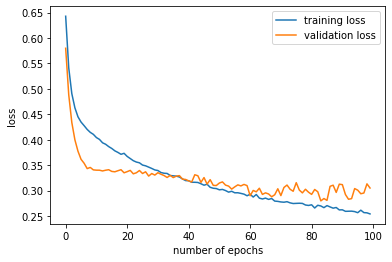

In [50]:
plt.plot(training_loss_history, label='training loss')
plt.plot(validation_loss_history, label='validation loss')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('loss')
#plt.savefig('/gdrive/MyDrive/DLMI/Project/train_val_loss.jpg')
plt.show()

#### Average predictions for CNN and MLP

Il faut avoir fait tourner un cnn et un mlp  
Les dernières modifs sur la sortie du resnet peut poser problème (dans ce cas vérifier l'output de resnet et rajouter ',_'

In [51]:
device = 'cuda'
model = CNN_v2()
model.load_state_dict(torch.load('/content/CNN_final_100e.save'))
model.to(device)

mlp = MLP()
mlp.load_state_dict(torch.load('/content/MLP_final_150e.save'))
mlp.to(device)
print('Importation des models')

Importation des models


In [52]:
model.eval()
mlp.eval()
predictions_avg = []
true_labels_avg = []
predictions_cnn = []
true_labels_cnn = []
predictions_mlp = []
true_labels_mlp = []
for patient_id in validation_ids:
    p_label = torch.from_numpy(validation_set[validation_set.ID == patient_id].LABEL.values)
    p_attr = np.array([validation_set[validation_set.ID == patient_id].age.item(), validation_set[validation_set.ID == patient_id].LYMPH_COUNT.item()])
    #p_attr = torch.tensor((p_attr - np.array([69.0, 21.43])) / np.array([17.5, 37.5])).float().to(device).unsqueeze(0)
    p_attr = torch.tensor((p_attr - np.array([70.65, 28.46])) / np.array([16.90, 49.26])).float().to(device).unsqueeze(0)
    output_cnn, _ = model(patient_id, device, 'trainset')
    output_mlp = mlp(p_attr)
    output = (output_cnn + output_mlp)/2
    #loss = criterion(output, p_label.float().to(device))
    
    predictions_avg += list(np.array((output > 0).int().cpu().detach()))
    true_labels_avg += list(np.array(p_label.int().cpu().detach()))

    predictions_cnn += list(np.array((output_cnn > 0).int().cpu().detach()))
    true_labels_cnn += list(np.array(p_label.int().cpu().detach()))

    predictions_mlp += list(np.array((output_mlp > 0).int().cpu().detach()))
    true_labels_mlp += list(np.array(p_label.int().cpu().detach()))

#validation_loss_history.append(validation_loss)
val_accuracy_avg = accuracy_score(true_labels_avg, predictions_avg)
val_balanced_accuracy_avg = balanced_accuracy_score(true_labels_avg, predictions_avg)
val_accuracy_cnn = accuracy_score(true_labels_cnn, predictions_cnn)
val_balanced_accuracy_cnn = balanced_accuracy_score(true_labels_cnn, predictions_cnn)
val_accuracy_mlp = accuracy_score(true_labels_mlp, predictions_mlp)
val_balanced_accuracy_mlp = balanced_accuracy_score(true_labels_mlp, predictions_mlp)
print("AVG Val Accuracy Score -> ", round(val_accuracy_avg, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy_avg, 4))
print("CNN Val Accuracy Score -> ", round(val_accuracy_cnn, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy_cnn, 4))
print("MLP Val Accuracy Score -> ", round(val_accuracy_mlp, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy_mlp, 4))

AVG Val Accuracy Score ->  0.9091 ; Val Balanced Accuracy Score ->  0.8929
CNN Val Accuracy Score ->  0.6364 ; Val Balanced Accuracy Score ->  0.5536
MLP Val Accuracy Score ->  0.9091 ; Val Balanced Accuracy Score ->  0.8929


In [53]:
df = pd.DataFrame({'true': true_labels_avg, 'cnn': predictions_cnn, 'mlp': predictions_mlp, 'avg': predictions_avg})
df['1o2'] = df.apply(lambda x: x['true'] if (x['cnn']==x['true'] or x['mlp']==x['true']) else x['cnn'], 1)

In [54]:
print('Accuracy Score -> ', accuracy_score(df.true.values, df['1o2'].values))
print('Balanced accuracy Score -> ', balanced_accuracy_score(df.true.values, df['1o2'].values))

Accuracy Score ->  0.9696969696969697
Balanced accuracy Score ->  0.9583333333333333


#### MOE training

##### Load pre-trained CNN and MLP

In [55]:
device = 'cuda'
model = CNN_v2()
model.load_state_dict(torch.load('/content/CNN_final_100e.save'))
model.to(device)

mlp = MLP()
mlp.load_state_dict(torch.load('/content/MLP_final_150e.save'))
mlp.to(device)
print('Importation des models')

Importation des models


##### Compute all prediction for the CNN

In [56]:
model.eval()

cnn_agg_patients_train = np.zeros((len(train_set.ID.values), 7*7*8*64))
cnn_score_patients_train = np.zeros(len(train_set.ID.values))
for i, patient_id in enumerate(train_set.ID.values):
    p_label = torch.from_numpy(train_set[train_set.ID == patient_id].LABEL.values)
    score_cnn, cnn_agg = model(patient_id, device, 'trainset')
    cnn_agg_patients_train[i] = np.array(cnn_agg.cpu().detach())
    cnn_score_patients_train[i] = np.array(score_cnn.cpu().detach())

cnn_agg_patients_val = np.zeros((len(validation_set), 7*7*8*64))
cnn_score_patients_val = np.zeros(len(validation_set))
for i, patient_id in enumerate(validation_set.ID.values):
    score_cnn, cnn_agg = model(patient_id, device, 'trainset')
    cnn_agg_patients_val[i] = np.array(cnn_agg.cpu().detach())
    cnn_score_patients_val[i] = np.array(score_cnn.cpu().detach())

In [57]:
print(cnn_agg_patients_train.shape)
print(cnn_score_patients_train.shape)
print(cnn_agg_patients_val.shape)
print(cnn_score_patients_val.shape)

(130, 25088)
(130,)
(33, 25088)
(33,)


##### MOE training

In [58]:
class MOE_Dataset(Dataset):
  def __init__(self, dataset, cnn_agg, cnn_scores):
    self.dataset = dataset
    self.cnn_agg = cnn_agg
    self.cnn_scores = cnn_scores
    self.ids = dataset.ID.values
    #self.attr_mean = np.array([69.0, 21.43])
    #self.attr_std = np.array([17.5, 37.5])
    #self.attr_mean = np.array([69.76, 26.42])
    #self.attr_std = np.array([17.61, 46.64])
    self.attr_mean = np.array([70.65, 28.46])
    self.attr_std = np.array([16.90, 49.26])

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    patient_id = self.ids[idx]
    x_agg = self.cnn_agg[idx]
    cnn_score = self.cnn_scores[idx]
    attributes = np.array([self.dataset[self.dataset.ID == patient_id].age.item(), self.dataset[self.dataset.ID == patient_id].LYMPH_COUNT.item()])
    attributes = (attributes - self.attr_mean)/self.attr_std
    label = self.dataset[self.dataset.ID == patient_id].LABEL.item()
    return torch.tensor(x_agg).float(), torch.tensor(cnn_score).float(), torch.tensor(attributes).float(), torch.tensor(label).float()


In [59]:
moe_trainset = MOE_Dataset(train_set, cnn_agg_patients_train, cnn_score_patients_train)
moe_trainloader = DataLoader(moe_trainset, batch_size=16, shuffle=True)
moe_valset = MOE_Dataset(validation_set, cnn_agg_patients_val, cnn_score_patients_val)
moe_valloader = DataLoader(moe_valset, batch_size=16, shuffle=True)

In [66]:
moe = MOE(7*7*8*64)
moe.to(device)
criterion = nn.BCELoss()
moe_optimizer = torch.optim.Adam(moe.parameters(), lr=1e-4, weight_decay=0.0005)

In [67]:
model.eval()
mlp.eval()

epochs = 200
training_loss_history = []
validation_loss_history = []
best_val_balanced_accuracy = 0
best_val_loss = 1
epoch_saved = 0
for epoch in range(epochs):
  training_loss = 0
  validation_loss = 0
  moe.train()
  predictions_train = []
  true_labels_train = []
  predictions = []
  true_labels = []
  for cnn_agg, score_cnn, p_attr, label in moe_trainloader:
    cnn_agg, score_cnn, p_attr, label = cnn_agg.to(device), score_cnn.to(device), p_attr.to(device), label.to(device)
    moe_optimizer.zero_grad()
    score_mlp = mlp(p_attr)
    prob_moe = moe(cnn_agg, p_attr)
    pred_moe = prob_moe * torch.sigmoid(score_cnn) + (1 - prob_moe) * torch.sigmoid(score_mlp.detach())
    loss = criterion(pred_moe, label)
    loss.backward()
    moe_optimizer.step()

    predictions_train += list(np.array((pred_moe > 0.5).int().cpu().detach()))
    true_labels_train += list(np.array(label.int().cpu().detach()))

    training_loss += loss.item()/len(train_set)
  training_loss_history.append(training_loss)
  lr_scheduler.step()
  
  moe.eval()
  for cnn_agg, score_cnn, p_attr, label in moe_valloader:
    cnn_agg, score_cnn, p_attr, label = cnn_agg.to(device), score_cnn.to(device), p_attr.to(device), label.to(device)
    score_mlp = mlp(p_attr)
    prob_moe = moe(cnn_agg, p_attr)
    pred_moe = prob_moe * torch.sigmoid(score_cnn) + (1 - prob_moe) * torch.sigmoid(score_mlp.detach())
    loss = criterion(pred_moe, label)

    validation_loss += loss.item()/len(validation_set)
    predictions += list(np.array((pred_moe > 0.5).int().cpu().detach()))
    true_labels += list(np.array(label.int().cpu().detach()))

  validation_loss_history.append(validation_loss)
  val_accuracy = accuracy_score(true_labels, predictions)
  val_balanced_accuracy = balanced_accuracy_score(true_labels, predictions)

  train_accuracy = accuracy_score(true_labels_train, predictions_train)
  train_balanced_accuracy = balanced_accuracy_score(true_labels_train, predictions_train)

  if validation_loss < best_val_loss:
      torch.save(moe.state_dict(), '/content/MOE_final_200e.save')
      best_val_balanced_accuracy = val_balanced_accuracy
      best_val_loss = validation_loss
      epoch_saved = epoch + 1

  
  print('Epoch [',epoch+1, '/', epochs, ']:------------------------------------')
  print('Training loss -> ', round(training_loss, 4), 'Validation loss -> ', round(validation_loss, 4))
  print("Train Accuracy Score -> ", round(train_accuracy, 4), "; Train Balanced Accuracy Score -> ",round(train_balanced_accuracy, 4))
  print("Val Accuracy Score -> ", round(val_accuracy, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy, 4))
  print('----------------------------------------------------------------------')

Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [ 1 / 200 ]:------------------------------------
Training loss ->  0.0159 Validation loss ->  0.0269
Train Accuracy Score ->  0.9231 ; Train Balanced Accuracy Score ->  0.8761
Val Accuracy Score ->  0.8182 ; Val Balanced Accuracy Score ->  0.7857
----------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [ 2 / 200 ]:------------------------------------
Training loss ->  0.0172 Validation loss ->  0.0416
Train Accuracy Score ->  0.9462 ; Train Balanced Accuracy Score ->  0.9079
Val Accuracy Score ->  0.7576 ; Val Balanced Accuracy Score ->  0.7202
----------------------------------------------------------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch [ 3 / 200 ]:------------------------------------
Training loss ->  0.0166 Validation loss ->  0.0528
Train Accuracy Score ->  0.9385 ; Train Balanced Accuracy Score ->  0.9025
Val Accuracy Score -

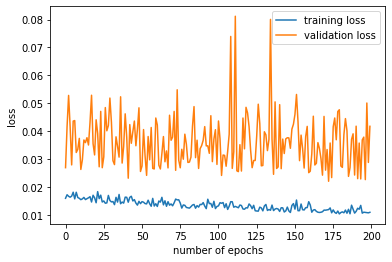

In [68]:
plt.plot(training_loss_history, label='training loss')
plt.plot(validation_loss_history, label='validation loss')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('loss')
#plt.savefig('/gdrive/MyDrive/DLMI/Project/train_val_loss.jpg')
plt.show()

#### Model predictions on training and validation set

In [69]:
device = 'cuda'
model = CNN_v2()
model.load_state_dict(torch.load('/content/model_CNN_130e.save'))
model.to(device)

mlp = MLP()
mlp.load_state_dict(torch.load('/content/model_MLP_100e_2.save'))
mlp.to(device)

moe = MOE(7*7*8*64)
moe.load_state_dict(torch.load('/content/model_final_MOE_200e.save'))
moe.to(device)
print('Importation des models')

Importation des models


In [70]:
model.eval()
mlp.eval()
moe.eval()
predictions_moe = []
true_labels_moe = []
predictions_cnn = []
true_labels_cnn = []
predictions_mlp = []
true_labels_mlp = []
for patient_id in validation_ids:
    p_label = torch.from_numpy(validation_set[validation_set.ID == patient_id].LABEL.values)
    p_attr = np.array([validation_set[validation_set.ID == patient_id].age.item(), validation_set[validation_set.ID == patient_id].LYMPH_COUNT.item()])
    p_attr = torch.tensor((p_attr - np.array([69.0, 21.43])) / np.array([17.5, 37.5])).float().to(device).unsqueeze(0)
    output_cnn, cnn_agg = model(patient_id, device, 'trainset')
    output_mlp = mlp(p_attr)
    output_moe = moe(cnn_agg, p_attr)
    output = output_moe * torch.sigmoid(output_cnn) + (1 - output_moe) * torch.sigmoid(output_mlp.detach())
    #loss = criterion(output, p_label.float().to(device))
    
    predictions_moe += list(np.array((output > 0.5).int().cpu().detach()))
    true_labels_moe += list(np.array(p_label.int().cpu().detach()))

    predictions_cnn += list(np.array((output_cnn > 0).int().cpu().detach()))
    true_labels_cnn += list(np.array(p_label.int().cpu().detach()))

    predictions_mlp += list(np.array((output_mlp > 0).int().cpu().detach()))
    true_labels_mlp += list(np.array(p_label.int().cpu().detach()))

#validation_loss_history.append(validation_loss)
val_accuracy_moe = accuracy_score(true_labels_moe, predictions_moe)
val_balanced_accuracy_moe = balanced_accuracy_score(true_labels_moe, predictions_moe)
val_accuracy_cnn = accuracy_score(true_labels_cnn, predictions_cnn)
val_balanced_accuracy_cnn = balanced_accuracy_score(true_labels_cnn, predictions_cnn)
val_accuracy_mlp = accuracy_score(true_labels_mlp, predictions_mlp)
val_balanced_accuracy_mlp = balanced_accuracy_score(true_labels_mlp, predictions_mlp)
print("MOE Val Accuracy Score -> ", round(val_accuracy_moe, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy_moe, 4))
print("CNN Val Accuracy Score -> ", round(val_accuracy_cnn, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy_cnn, 4))
print("MLP Val Accuracy Score -> ", round(val_accuracy_mlp, 4), "; Val Balanced Accuracy Score -> ",round(val_balanced_accuracy_mlp, 4))

MOE Val Accuracy Score ->  0.9394 ; Val Balanced Accuracy Score ->  0.9345
CNN Val Accuracy Score ->  0.7576 ; Val Balanced Accuracy Score ->  0.7202
MLP Val Accuracy Score ->  0.8788 ; Val Balanced Accuracy Score ->  0.869


In [ ]:
df = pd.DataFrame({'true': true_labels_avg, 'cnn': predictions_cnn, 'mlp': predictions_mlp, 'moe': predictions_moe})
df['1o2'] = df.apply(lambda x: x['true'] if (x['cnn']==x['true'] or x['mlp']==x['true']) else x['cnn'], 1)

In [ ]:
print('Accuracy Score -> ', accuracy_score(df.true.values, df['1o2'].values))
print('Balanced accuracy Score -> ', balanced_accuracy_score(df.true.values, df['1o2'].values))

Accuracy Score ->  0.9393939393939394
Balanced accuracy Score ->  0.9236111111111112


# Submission to Kaggle Competition

### MLP predictions

Use this prediction method to obtain kaggle results

In [ ]:
mlp = MLP()
mlp.load_state_dict(torch.load('/content/MLP_final_150e.save'))
mlp.to(device)

In [ ]:
model.eval()
mlp.eval()
moe.eval()
y_pred_kaggle = []
IDs = []
test_index = testset_meta.index.values
test_IDs = testset_meta.ID
for patient_index in test_index:
    p_attr = np.array([testset_meta.loc[patient_index].age, testset_meta.loc[patient_index].LYMPH_COUNT])
    p_attr = torch.tensor((p_attr - np.array([70.65, 28.46])) / np.array([16.90, 49.26])).float().to(device).unsqueeze(0)
    patient_id = testset_meta.loc[patient_index].ID
    output_mlp = mlp(p_attr)
    
    y_pred_kaggle += list(np.array((output_mlp > 0).int().cpu().detach()))
    IDs.append(testset_meta.loc[patient_index].ID)

In [ ]:
print('Testing set length -> ', len(y_pred_kaggle))
print('Positive predicted -> ', sum(y_pred_kaggle), ' (', sum(y_pred_kaggle)/len(y_pred_kaggle), '%)')

Testing set length ->  42
Positive predicted ->  28  ( 0.6666666666666666 %)


In [ ]:
submission = pd.DataFrame({'ID' : test_IDs, 'Predicted' : y_pred_kaggle}).set_index('ID')

In [ ]:
submission.to_csv('/content/submission.csv')

In [ ]:
!kaggle competitions submit -c 3md3070-dlmi -f submission.csv -m "Submission MLP"

100% 282/282 [00:00<00:00, 411B/s]
Successfully submitted to 3MD3070-DLMI

### AVG

 Do not use this one for predictions on test set

In [84]:
device = 'cuda'
model = CNN_v2()
model.load_state_dict(torch.load('/content/CNN_final_100e.save'))
model.to(device)

mlp = MLP()
mlp.load_state_dict(torch.load('/content/MLP_final_150e.save'))
mlp.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [85]:
model.eval()
mlp.eval()
moe.eval()
y_pred_kaggle = []
IDs = []
test_index = testset_meta.index.values
test_IDs = testset_meta.ID
for patient_index in test_index:
    p_attr = np.array([testset_meta.loc[patient_index].age, testset_meta.loc[patient_index].LYMPH_COUNT])
    p_attr = torch.tensor((p_attr - np.array([70.65, 28.46])) / np.array([16.90, 49.26])).float().to(device).unsqueeze(0)
    patient_id = testset_meta.loc[patient_index].ID
    #output_cnn, cnn_agg = model(patient_id, device, 'testset')
    output_mlp = mlp(p_attr)
    #output = 0.5 * (output_cnn + output_mlp)
    #loss = criterion(output, p_label.float().to(device))
    
    y_pred_kaggle += list(np.array((output_mlp > 0).int().cpu().detach()))
    IDs.append(testset_meta.loc[patient_index].ID)

### MOE

Do not use this one for predictions on test set

We first load all 3 trained models (CNN, MLP and MOE)

In [ ]:
device = 'cuda'
model = CNN_v2()
model.load_state_dict(torch.load('/content/CNN_final_100e.save'))
model.to(device)

mlp = MLP()
mlp.load_state_dict(torch.load('/content/MLP_final_150e_v2.save'))
mlp.to(device)

moe = MOE(7*7*8*64)
moe.load_state_dict(torch.load('/content/MOE_final_200e.save'))
moe.to(device)
print('Importation des models')

Importation des models


Make predictions on the testing set

In [ ]:
self.attr_mean = np.array([70.65, 28.46])
    self.attr_std = np.array([16.90, 49.26])

In [71]:
model.eval()
mlp.eval()
moe.eval()
y_pred_kaggle = []
IDs = []
test_index = testset_meta.index.values
test_IDs = testset_meta.ID
for patient_index in test_index:
    p_attr = np.array([testset_meta.loc[patient_index].age, testset_meta.loc[patient_index].LYMPH_COUNT])
    p_attr = torch.tensor((p_attr - np.array([70.65, 28.46])) / np.array([16.90, 49.26])).float().to(device).unsqueeze(0)
    patient_id = testset_meta.loc[patient_index].ID
    output_cnn, cnn_agg = model(patient_id, device, 'testset')
    output_mlp = mlp(p_attr)
    output_moe = moe(cnn_agg, p_attr)
    output = output_moe * torch.sigmoid(output_cnn) + (1 - output_moe) * torch.sigmoid(output_mlp.detach())
    #loss = criterion(output, p_label.float().to(device))
    
    y_pred_kaggle += list(np.array((output > 0.5).int().cpu().detach()))
    IDs.append(testset_meta.loc[patient_index].ID)

In [86]:
print('Testing set length -> ', len(y_pred_kaggle))
print('Positive predicted -> ', sum(y_pred_kaggle), ' (', sum(y_pred_kaggle)/len(y_pred_kaggle), '%)')

Testing set length ->  42
Positive predicted ->  28  ( 0.6666666666666666 %)


In [87]:
submission = pd.DataFrame({'ID' : test_IDs, 'Predicted' : y_pred_kaggle}).set_index('ID')

In [88]:
submission.to_csv('/content/submission.csv')

In [89]:
!kaggle competitions submit -c 3md3070-dlmi -f submission.csv -m "Submission MOE"

100% 282/282 [00:00<00:00, 411B/s]
Successfully submitted to 3MD3070-DLMI